In [66]:
import torch.nn as nn
import torch

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [49]:
from data.dataloader import data_generator
from training.optimizer import get_optimizer
from models.losses import loss_function
from models.utils import eigen_decomp

In [50]:
from models.gru_denoiser import BiGRUSpectralDenoiser

à evoquer calcul dans GRU :
$$\hat{\Sigma} = \hat{Q} \hat{\Lambda} \hat{Q}^T$$

$$\tilde{\Sigma}_{NN} = \hat{Q} \tilde{\Lambda}_{NN} \hat{Q}^T$$

## NN

In [51]:
model = BiGRUSpectralDenoiser(hidden_size=64) # hidden_size to be tunned

### Training loop

On pourra rajouter dans la loss un terme pour comparer les valeurs propres/les matrices totals par exemples des matrices.

On pourrait calculer la loss par epochs d'une tailles plus petites ou même aléatoire

In [52]:
losses = []

In [53]:
N_min=80
N_max=200
T_min=80
T_max=200

In [54]:
optimizer = get_optimizer(model)

In [55]:
# batch are full for now
batch_size = 32 # to be tunned
epochs = 250

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    lam_emp, Q_emp, Sigma_true, T = next(data_generator(batch_size, N_min=N_min, N_max=N_max, T_min=T_min, T_max=T_max))
    lam_pred = model(lam_emp)  # forward pass through the NN (GRU+fc)

    # compute losses
    loss = loss_function(lam_pred, Q_emp, Sigma_true, T)

    # backprop
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # very noisy optimization we could lower lr as loss deacreases
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} — loss: {loss.item():.6f}")


Epoch 10/250 — loss: 0.295008
Epoch 20/250 — loss: 0.294754
Epoch 30/250 — loss: 0.161439
Epoch 40/250 — loss: 0.090963
Epoch 50/250 — loss: 0.103917
Epoch 60/250 — loss: 0.104435
Epoch 70/250 — loss: 0.054193
Epoch 80/250 — loss: 0.107731
Epoch 90/250 — loss: 0.044214
Epoch 100/250 — loss: 0.033420
Epoch 110/250 — loss: 0.043631
Epoch 120/250 — loss: 0.053518
Epoch 130/250 — loss: 0.040946
Epoch 140/250 — loss: 0.065560
Epoch 150/250 — loss: 0.044075
Epoch 160/250 — loss: 0.070264
Epoch 170/250 — loss: 0.073639
Epoch 180/250 — loss: 0.079507
Epoch 190/250 — loss: 0.072566
Epoch 200/250 — loss: 0.049435
Epoch 210/250 — loss: 0.060083
Epoch 220/250 — loss: 0.033456
Epoch 230/250 — loss: 0.042339
Epoch 240/250 — loss: 0.043710
Epoch 250/250 — loss: 0.046947


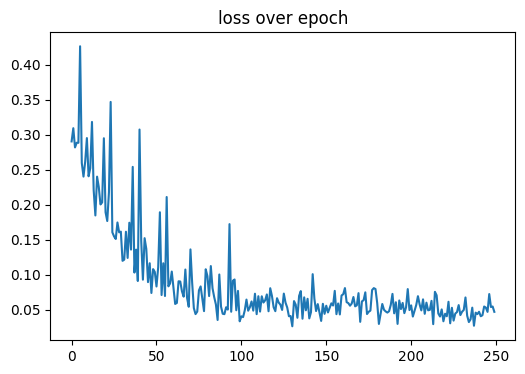

In [67]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("loss over epoch")
plt.savefig("images/training_loss.png")
plt.show()

might go up and down because it really depends on the N and T randomly picked.

we have to stop after the slow down of deacrese. otherwise we might face overfitting

### out of sample comparaison 1

In [68]:
batch_size_oos_1 = 25
N_list_test_1 = [20, 40, 60, 80, 100, 120, 140, 160, 180,200,220]
T_list_test_1 = [20, 40,60, 80, 100, 120, 150, 180, 200, 220, 240, 260, 280, 300]

In [69]:
losses_value = []

In [70]:
for n in N_list_test_1:
    for t in T_list_test_1:
        lam_emp_oos_i, Q_emp_oos_i, Sigma_true_oos_i, T_t = next(data_generator(batch_size_oos_1, N_min=n, N_max=n, T_min=t, T_max=t))
        lam_pred_test_i = model(lam_emp_oos_i)
        losses_value.append(loss_function(lam_pred_test_i, Q_emp_oos_i, Sigma_true_oos_i, T_t).item())

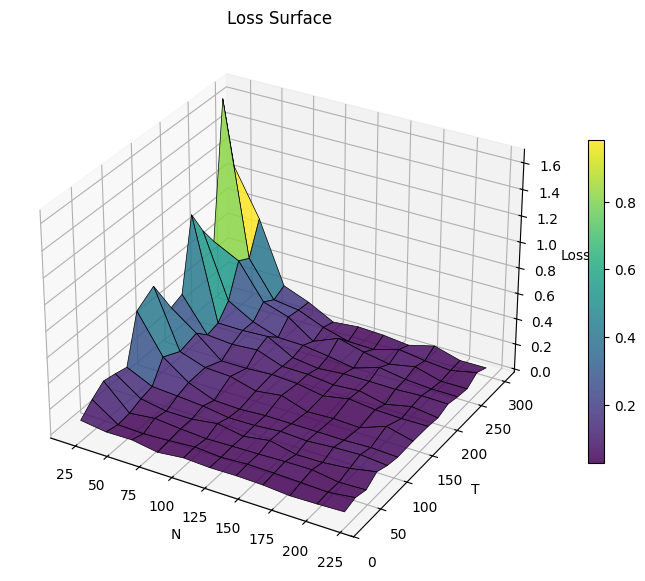

In [71]:
# meshing
loss_grid = np.array(losses_value).reshape(len(np.array(N_list_test_1)), len(np.array(T_list_test_1)))
N_mesh, T_mesh = np.meshgrid(np.array(N_list_test_1), np.array(T_list_test_1), indexing='ij')

# plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(N_mesh, T_mesh, loss_grid,
                       cmap='viridis',
                       edgecolor='k',
                       linewidth=0.5,
                       alpha=0.85)

ax.set_xlabel("N")
ax.set_ylabel("T")
ax.set_zlabel("Loss")
ax.set_title("Loss Surface")

fig.colorbar(surf, shrink=0.6)
plt.savefig('images/loss_surface.png')
plt.show()

### out of sample comparaison 2

In [79]:
batch_size_oos = 200

In [88]:
lam_emp_oos, Q_emp_oos, Sigma_true_oos, T = next(data_generator(batch_size_oos, N_min=200, N_max=200, T_min=100, T_max=100))


In [89]:
lam_pred_test = model(lam_emp_oos)

Comparaison eigenvalues $\lambda$

In [90]:
# mse
mse = nn.MSELoss()

In [91]:
lam_true_oos = torch.tensor(np.array([eigen_decomp(Sigma.numpy())[0] for Sigma in Sigma_true_oos]), dtype=torch.float32)


mse_pred_test_lam  = mse(lam_pred_test, lam_true_oos)
mse_noisy_test_lam = mse(lam_true_oos, lam_emp_oos.squeeze(-1))

print(f"MSE cleaned: {mse_pred_test_lam:.6f}")
print(f"MSE noisy  : {mse_noisy_test_lam:.6f}")


MSE cleaned: 0.006959
MSE noisy  : 0.089491


Comparaison Trace

In [92]:
trace_true_test = lam_true_oos.sum(dim=1).mean()
trace_pred_test = lam_pred_test.sum(dim=1).mean()
trace_noisy_test = lam_emp_oos.sum(dim=1).mean()

mse_tr_test_pred = mse(trace_true_test,trace_pred_test)
mse_tr_test_noisy = mse(trace_true_test,trace_noisy_test)

print(f"Real Trace : {trace_true_test:.4f}, predicted : {trace_pred_test:.4f}, noisy : {trace_noisy_test:.4f}")

print(f"MSE tr noisy  : {mse_tr_test_noisy:.6f}")
print(f"MSE tr cleaned: {mse_tr_test_pred:.6f}")

Real Trace : 55.2586, predicted : 54.7414, noisy : 54.7517
MSE tr noisy  : 0.256983
MSE tr cleaned: 0.267488


*10^6 fois mieux

Comparaison matrix $\Sigma$

In [93]:
def reconstruct_cov(Q, lam):
    Lambda = torch.diag_embed(lam.squeeze(-1))
    Sigma = Q @ Lambda @ Q.transpose(1, 2)
    return Sigma

In [94]:
Sigma_true_test = Sigma_true_oos
Sigma_noisy_test = reconstruct_cov(Q_emp_oos, lam_emp_oos)
Sigma_pred_test   = reconstruct_cov(Q_emp_oos, lam_pred_test)

fro_noisy_test_mat = mse(Sigma_noisy_test, Sigma_true_test)
fro_pred_test_mat   = mse(Sigma_pred_test, Sigma_true_test)

print(f"mse error (noisy):  {fro_noisy_test_mat:.6f}")
print(f"mse error (GRU)  :  {fro_pred_test_mat:.6f}")

mse error (noisy):  0.001087
mse error (GRU)  :  0.000485


supérieur à *10^6 fois mieux

Graphique : 

In [95]:
pairs = ['Matrix', 'Trace', 'EigenValues']
mse_noisy   = [fro_noisy_test_mat.item(), mse_tr_test_noisy.item(), mse_noisy_test_lam.item()]
mse_cleaned = [fro_pred_test_mat.item(), mse_tr_test_pred.item(), mse_pred_test_lam.item()]

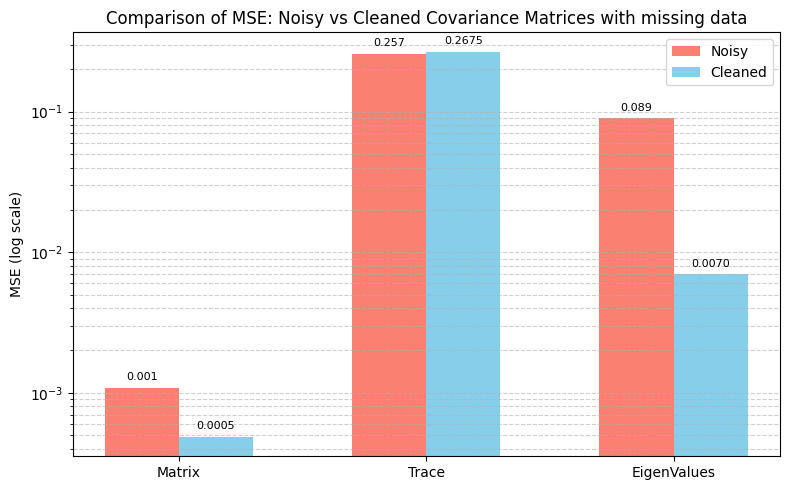

In [96]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(pairs))
width = 0.3

plt.figure(figsize=(8,5))
plt.bar(x - width/2, mse_noisy, width, label='Noisy', color='salmon')
plt.bar(x + width/2, mse_cleaned, width, label='Cleaned', color='skyblue')

plt.yscale('log')
plt.ylabel('MSE (log scale)')
plt.xticks(x, pairs)
plt.legend()
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.6)

for i, (n, c) in enumerate(zip(mse_noisy, mse_cleaned)):
    plt.text(x[i] - width/2, n*1.1, f"{n:.3f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i] + width/2, c*1.1, f"{c:.4f}", ha='center', va='bottom', fontsize=8)

plt.title('Comparison of MSE: Noisy vs Cleaned Covariance Matrices with missing data')
plt.tight_layout()
plt.savefig('images/results_NN_oos')
plt.show()


### Add comparaison

#### Comparaison with no missing value

#### Comparaison with RIE estimator on no missing value

### Add hyperparameter selection

### Loss that minimizes the Portfolio Risk

To be added
- we could add : eigenvalues monotonically decreasing
- hyperparameter tuning

To be written in the report
- write abt RIE and that we do smt simular
- write abt GRU and how it helps us here
- a problem is that eigenVector are noisy